In [1]:
%load_ext autoreload
%autoreload 2
import os

os.chdir("/home/jorge/thesis")

import torch
from pytorch3d.renderer import FoVPerspectiveCameras
from text3d2video.util import read_obj_with_uvs

torch.set_grad_enabled(False)

# read mesh
mesh_path = "data/meshes/cat_statue.obj"

device = "cuda"
mesh, verts_uvs, faces_uvs = read_obj_with_uvs(mesh_path)

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: data/meshes/cat_statue.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


# Setup Image & initial texture

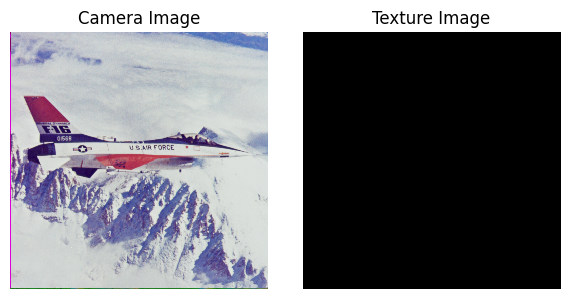

In [2]:
import torch
from torchvision.io import read_image
import torchvision.transforms.functional as TF

from text3d2video.util import chw_to_hwc
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.testing_utils import checkerboard_img

TEXTURE_RES = 700
CAMERA_RES = 512

texture_image = chw_to_hwc(
    checkerboard_img(
        return_type="pt",
        res=TEXTURE_RES,
        square_size=30,
        color1=(200, 200, 200),
        color2=(256, 256, 256),
    )
).cuda()

texture_image = torch.zeros_like(texture_image) 

camera_image = read_image("data/images/airplane.png") / 255
camera_image = TF.resize(camera_image, (CAMERA_RES, CAMERA_RES)).cuda()

# Plot the images
texture_im = texture_image.cpu()
camera_image_im = TF.to_pil_image(camera_image.cpu())
display_ims(
    [camera_image_im, texture_im], titles=["Camera Image", "Texture Image"], scale=3
)

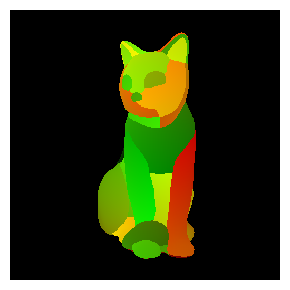

In [3]:
from text3d2video.rendering import render_rgb_uv_map, render_texture
from text3d2video.utilities.camera_placement import turntable_extrinsics

R, T = turntable_extrinsics(angles=0, dists=2)
cam = FoVPerspectiveCameras(R=R, T=T, device=device, fov=40)

display_ims(render_rgb_uv_map(mesh, cam, verts_uvs, faces_uvs))

In [4]:
from text3d2video.backprojection import (
    compute_texel_projection,
)

projection = compute_texel_projection(
    mesh,
    cam,
    verts_uvs,
    faces_uvs,
    raster_res=3000,
    texture_res=TEXTURE_RES,
)

torch.cuda.empty_cache()
# display_projection(projection, uv_image=None, xy_image=None, s=5)

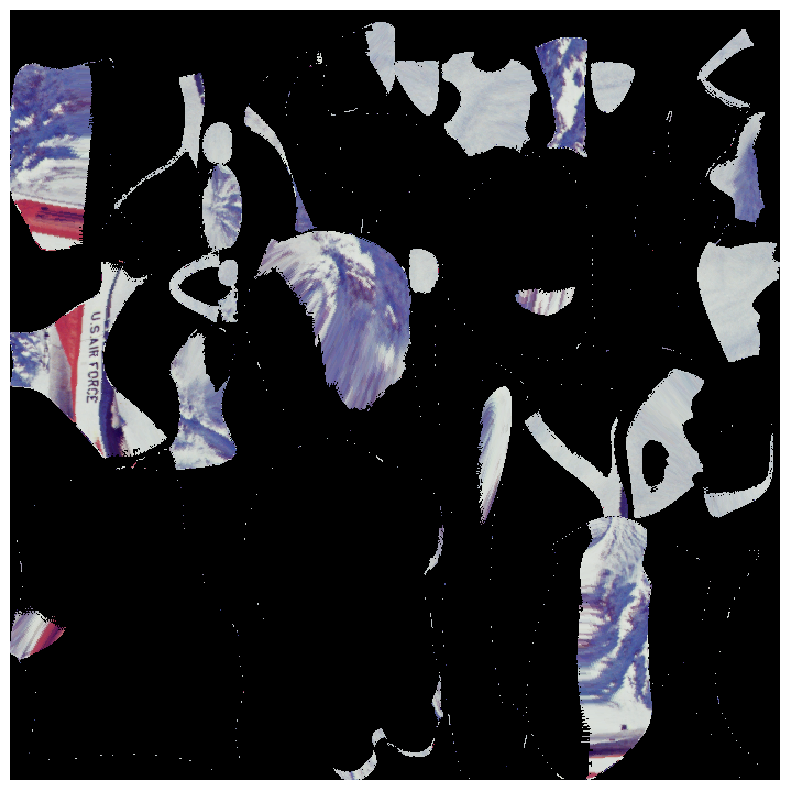

In [5]:
from text3d2video.util import sample_feature_map_ndc
from text3d2video.utilities.ipython_utils import display_ims

xy_coords_ndc = projection.xys.clone()

colors = sample_feature_map_ndc(camera_image, xy_coords_ndc)

updated_texture = texture_image.clone()
updated_texture[projection.uvs[:, 1], projection.uvs[:, 0]] = colors

display_ims([updated_texture.cpu()], scale=8)

In [ ]:
import numpy as np
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.video_comparison import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip
from pytorch3d.renderer import FoVPerspectiveCameras

angles = np.linspace(0, 360, 36, endpoint=False)
R, T = turntable_extrinsics(angles=angles, dists=2)
cams = FoVPerspectiveCameras(R=R, T=T, device='cuda', fov=40)
render_meshes = mesh.extend(len(angles))

renders = render_texture(
    render_meshes,
    cams,
    updated_texture,
    verts_uvs,
    faces_uvs,
    return_pil=True,
    sampling_mode="nearest",
)

display_vid(pil_frames_to_clip(renders))

: 